# Libraries
first, we will import all the libraries we will need later on.


In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import json
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from scipy.stats import loguniform
from imblearn.under_sampling import RandomUnderSampler
import joblib

# Loading the processed Data

Next, we load the dataset we have worked on in preprocessing notebook.


In [2]:
X_train = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/X_train.csv')
X_test = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/X_test.csv')
y_train = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/y_train.csv')['Class']
y_test = pd.read_csv('/Users/raya/Desktop/fraud-detection/european-dataset/data/processed/y_test.csv')['Class']

# OverSampling/UnderSampling

We are going to explore three sets of training data:
- The original imbalanced training data
- Oversampled training data
- Undersampled training data

We use *SMOTE* (Synthetic Minority Oversampling Technique) Algorithm for oversampling which is an oversampling method for imbalanced datasets. It creates synthetic minority class samples by interpolating between existing ones and their nearest neighbors, balancing the dataset to improve model performance without simply duplicating data.

![credit : https://www.google.com/url?sa=i&url=https%3A%2F%2Fpub.aimind.so%2Fsynthetic-minority-over-sampling-technique-smote-empowering-ai-through-imbalanced-data-handling-d86f4de32ea3&psig=AOvVaw3VxNyFvCIVrxpdphD8Yz9O&ust=1753288171479000&source=images&cd=vfe&opi=89978449&ved=0CBgQjhxqFwoTCKCMqsjx0I4DFQAAAAAdAAAAABAM](https://miro.medium.com/v2/resize:fit:850/1*QaNfJwU6P-VnG1zp3U4cVg.png)

In [4]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [5]:
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)


# Training
Now, we define the parameter distribution for the random search to find the best combination of hyperparameters. We use three sets of training data to compare the results later.


In [6]:
datasets = [
    ('original', X_train, y_train),
    ('smote', X_train_smote, y_train_smote),
    ('undersampled', X_train_under, y_train_under)
]
svm = SVC(kernel='rbf', probability=True, random_state=42)
param_dist = {
    'C': loguniform(1e-3, 1e3),  # Regularization parameter
    'gamma': loguniform(1e-4, 1e0),  # Kernel coefficient
    'class_weight': [{0: 1, 1: w} for w in [1, 10, 50, 100, 200]]  # Weight for fraud class
}

Now, we train the model on these three sets and save them for future use.

In [ ]:
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings to sample
    scoring='f1',  # Optimize for F1-score
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=2,
    random_state=42,
)

for dataset_name,feature_set,target_set in datasets:
    print('training model with',dataset_name,'dataset...')
    random_search.fit(feature_set, target_set)
    best_model = random_search.best_estimator_
    print(random_search.best_params_)
    model_name = 'svm_'+dataset_name+'.joblib'
    joblib.dump(best_model, model_name)
    print('model',model_name,'saved.')

training model with original dataset...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


# Evaluation
Now that we have trained the models, it’s time to compare and record their performance. Since the data is highly imbalanced, we need to use an appropriate metric to accurately capture the models’ performance. For this purpose, we use the F1 score.

In [ ]:
results = []
for dataset_name, _, _ in datasets:
    model_name = 'svm_' + dataset_name + '.joblib'
    model = joblib.load(model_name)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    results.append({
        'dataset': dataset_name,
        'precision': precision,
        'f1_score': f1
    })
    print(f"\nMetrics for dataset: {dataset_name}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")

In [10]:
model_name = '/Users/raya/Desktop/fraud-detection/european-dataset/models/svm_original.joblib'
model = joblib.load(model_name)
y_pred = model.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [14]:
metrics = {
    'Accuracy': float(accuracy),
    'Precision': float(precision),
    'Recall': float(recall),
    'F1-score': float(f1),
    'True Positives': float(tp),
    'False Positives': float(fp),
    'True Negatives': float(tn),
    'False Negatives': float(fn),
}
with open('/Users/raya/Desktop/fraud-detection/european-dataset/reports/svm/metrics.json', 'w') as f:
    json.dump(metrics, f,indent=4)

We can also plot the confusion matrix to gain a better understanding of the model’s performance.


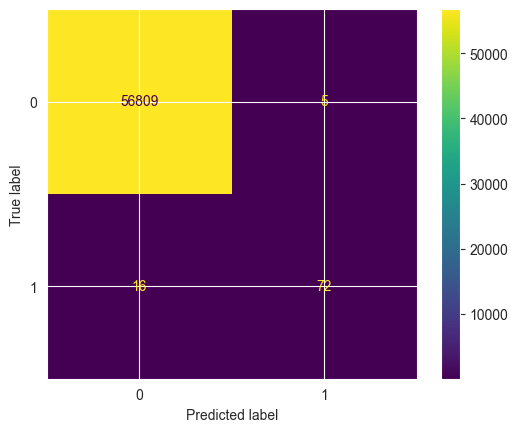

In [15]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()